# 20240430
- __getitem__()에서 형태소의 벡터를 받는게 아니라 음절의 벡터를 받음.. 학습 다시 할 필요가 있음

- fasttext model에서 특수문자의 경우 영행렬을 출력. 특수문자에 대한 처리가 필요해보임.

In [1]:
import pandas as pd
import hgtk
from tqdm import tqdm
import fasttext

In [3]:
from torch.utils.data import random_split, DataLoader, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt

In [64]:
def decompose(form):
    word = ''
    try:
        for s in form:
            if s == ' ':
                word += ''
            elif hgtk.checker.is_hangul(s):
                a, b, c = hgtk.letter.decompose(s)
                if not a:
                    a = '-'
                if not b:
                    b = '-'
                if not c:
                    c = '-'
                word = word + a + b + c
    except:
        print(form)
    return word

In [4]:
fast_model = fasttext.load_model("fasttext_with_NIKL_MP_CSV.bin") # 모델 로드

In [92]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, num_word, transform = None, target_transform=None):
        file = open(data_dir, 'r')
        self.ori_data = []
        for line in file:
            morphs, label = line.split('\t')
            self.ori_data.append((morphs, int(label)))
            if len(self.ori_data) == 5000:
                break
        self.data = self.ori_data
        self.transform = transform
        self.target_transform = target_transform
        self.num_word = num_word
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        sent = self.data[i][0]
        padded_vec = torch.zeros((self.num_word, fast_model.get_dimension()), dtype = torch.float32)
        
        sent2vec = []
        x = ''
        for m in sent.split():
            if m.rstrip():
                sent2vec.append(fast_model.get_word_vector(decompose(m)))
        sent2vec = np.array(sent2vec)
        len_sent = len(sent2vec)
        if len_sent > self.num_word:
            len_sent = self.num_word
        padded_vec[(self.num_word - len_sent):] = torch.from_numpy(sent2vec[:len_sent])
         
            
        label = torch.tensor(self.data[i][1], dtype = torch.float32)
        return (padded_vec, label)

In [93]:
dataset = CustomDataset('./morphs_label.txt', num_word=64)

In [7]:
t = 0
f = 0
for (_, y) in dataset.data:
    if y:
        t += 1
    else:
        f += 1

print(f'label \'1\' : {t} / label \'0\' : {f}')

label '1' : 99996 / label '0' : 99996


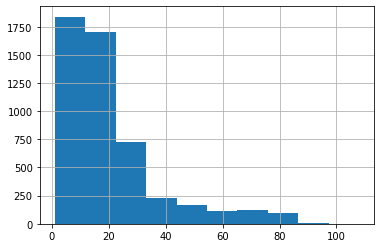

count    5000.000000
mean       20.227600
std        17.203633
min         1.000000
25%         9.000000
50%        15.000000
75%        25.000000
max       108.000000
dtype: float64

In [94]:
sent_len = [len(s[0].split()) for s in dataset.data]
pd.Series(sent_len).hist()
plt.show()
pd.Series(sent_len).describe()

In [123]:
dic = {}

for n in sent_len:
    if n in dic:
        dic[n] += 1
    else:
        dic[n] = 1

In [124]:
dic = sorted(dic.items())

In [127]:
total_cnt = 0
for (length, cnt) in dic:
    total_cnt += cnt
    if length == 64:
        print(total_cnt / len(sent_len) * 100)
        break
        
    if (total_cnt / len(sent_len)) * 100 > 90:
        print(length, total_cnt)

44 4514
45 4533
46 4547
47 4562
48 4574
49 4585
50 4604
51 4617
52 4634
53 4653
54 4663
55 4678
56 4687
57 4693
58 4705
59 4719
60 4732
61 4741
62 4753
63 4761
95.38


In [95]:
train_size = int(len(dataset) * 0.8)
valid_size = len(dataset) - train_size
batch_size = 32

In [96]:
train_data, valid_data = random_split(dataset, [train_size, valid_size])

In [97]:
train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size = batch_size, shuffle=True)

In [98]:
train_sent, train_label = next(iter(train_dataloader))
print(train_sent)
print(train_label)
print(train_sent.size())

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 1.3145, -0.2798, -1.4416,  ...,  1.1470,  0.4726, -0.6241],
         [ 1.3366, -0.4688, -0.3392,  ...,  0.9229,  0.4649, -0.6741],
         [ 4.0056, -0.9015,  0.8713,  ...,  3.2828,  0.5830, -1.8416]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [-0.4440,  0.2635, -0.6499,  ...,  0.2165, -0.0686, -0.6262],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0

In [4]:
class SentimentLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_dim):
        super(SentimentLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.output_dim = output_dim
        
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=num_layers,batch_first = True)
        
        self.linear = nn.Linear(self.hidden_size, self.output_dim)
        self.dropout = nn.Dropout(0.3)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        batch_size = x.size(0)
        lstm_out, _ = self.lstm(x)
        
        drop_out = self.dropout(lstm_out)
        re_drop_out = drop_out.reshape([-1, self.hidden_size])
            
        linear_out = self.linear(re_drop_out)
        
        sig_out = self.sig(linear_out).reshape([batch_size, -1])[:, -1]
        
        return sig_out
        
    def init_hidden(self, batch_size, device):
        h0 = torch.zeros((self.num_layers, batch_size, self.hidden_size), dtype=torch.float32).to(device)
        c0 = torch.zeros((self.num_layers, batch_size, self.hidden_size), dtype=torch.float32).to(device)
        
        return (h0, c0)

In [5]:
num_layers = 2
input_size = 100
hidden_size = 128
output_dim = 1

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [6]:
lstm_model = SentimentLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_dim=output_dim)

In [30]:
lstm_model.to(device)

SentimentLSTM(
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (sig): Sigmoid()
)

In [32]:
lr = 0.001
clip = 5hhh
epochs = 5

loss_func = nn.BCELoss()#.to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr = lr)

def acc(pred, label):
    correct = torch.eq(pred.round(), label).sum().item()
    return correct

In [33]:
epoch_tr_acc, epoch_tr_loss = [], []
epoch_vl_acc, epoch_vl_loss = [],[]
for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    lstm_model.train()
    #h = lstm_model.init_hidden(batch_size, device)

    for inputs, labels in tqdm(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        #h = tuple([each.data for each in h])
        
        pred = lstm_model(inputs)
        
        loss = loss_func(pred, labels)
        loss.backward()
        train_losses.append(loss.item())
        
        accuracy = acc(pred, labels)

        train_acc += accuracy
        
        nn.utils.clip_grad_norm_(lstm_model.parameters(), clip)
        optimizer.step()
        optimizer.zero_grad()

    epoch_train_loss = np.mean(train_losses)
    epoch_train_acc = train_acc/len(train_dataloader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_tr_acc.append(epoch_train_acc)
    
    val_losses = []
    val_acc = 0.0
    lstm_model.eval()
    #val_h = lstm_model.init_hidden(batch_size, device)

    for inputs, labels in tqdm(valid_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        #val_h = tuple([each.data for each in val_h])
        pred = lstm_model(inputs)

        val_loss = loss_func(pred, labels.float())
        val_losses.append(val_loss.item())
        accuracy = acc(pred, labels)

        val_acc += accuracy
    
    epoch_val_loss = np.mean(val_losses)
    epoch_val_acc = val_acc/len(valid_dataloader.dataset)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_vl_acc.append(epoch_val_acc)

    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    print(25*'==')

100%|██████████| 1250/1250 [01:54<00:00, 10.96it/s]


Epoch 1
train_loss : 0.444022499114275 val_loss : 0.37458461055755615
train_accuracy : 78.48718381429187 val_accuracy : 82.79206980174504


100%|██████████| 1250/1250 [01:53<00:00, 11.05it/s]


Epoch 2
train_loss : 0.3554870865806937 val_loss : 0.3510391863703728
train_accuracy : 83.91992149656548 val_accuracy : 84.1096027400685


100%|██████████| 1250/1250 [01:53<00:00, 11.04it/s]


Epoch 3
train_loss : 0.31960278828293087 val_loss : 0.3499793401360512
train_accuracy : 85.75937697274256 val_accuracy : 84.42711067776695


100%|██████████| 1250/1250 [01:53<00:00, 11.04it/s]


Epoch 4
train_loss : 0.2939752895206213 val_loss : 0.3363282492995262
train_accuracy : 87.20006500284387 val_accuracy : 85.02962574064351


100%|██████████| 1250/1250 [01:52<00:00, 11.09it/s]

Epoch 5
train_loss : 0.2707769193381071 val_loss : 0.3432264690220356
train_accuracy : 88.26073640721782 val_accuracy : 85.16462911572789


In [34]:
torch.save(lstm_model, f='./k_sentiment_Fasttext_LSTM.bin')

In [7]:
model_x = torch.load('./k_sentiment_Fasttext_LSTM.bin')

In [8]:
model_x

SentimentLSTM(
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (sig): Sigmoid()
)

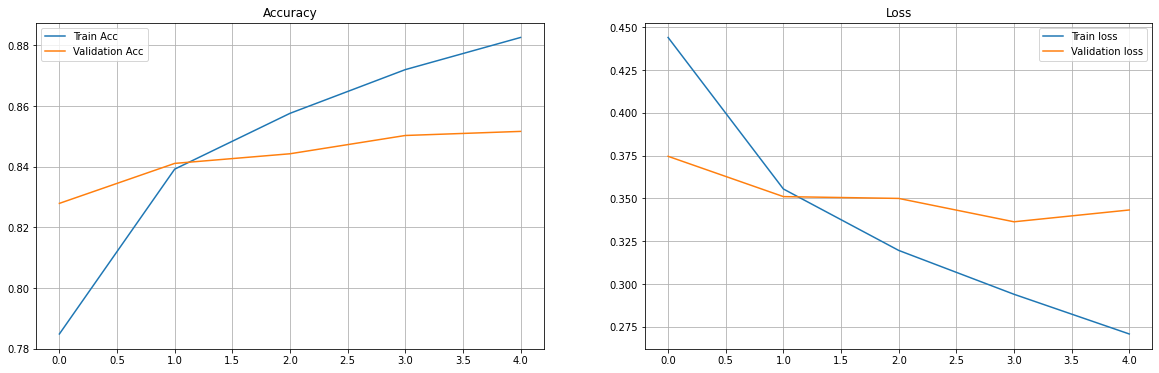

In [37]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [11]:
f = open('./morphs_label.txt', 'r')

In [12]:
l = f.readline()
l

'내용 괜찮 네 . 그리고 최윤소 아무리 봐 도 너무 예쁘 다 . \t1\n'

In [13]:
sentencel.split('\t')[0]

['내용 괜찮 네 . 그리고 최윤소 아무리 봐 도 너무 예쁘 다 . ', '1\n']

In [ ]:
def sent2tensor(sentence, num_word):
    
    